In [38]:
from rockit import *
from casadi import SX, MX, vertcat, cross, fabs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pyquaternion import Quaternion

In [2]:
ocp = Ocp(t0=0, T=FreeTime(100))

In [3]:
Tmax = 0.000953
Wmax = 1570.79632679
Vmax = 6
a_1 = np.array([[1],[0],[0]])
a_2 = np.array([[0],[1],[0]])
a_3 = np.array([[0],[0],[1]])
a_mat = np.concatenate((a_1, a_2, a_3), axis=1)
I = np.array([[0.04, 0.00, 0.00],
              [0.00, 0.05, 0.02],
              [0.00, 0.02, 0.05]])
I_inv = np.linalg.inv(I)
I_rw = 6.25E-05
I_wheels = I_rw*(a_1*np.transpose(a_1) + a_2*np.transpose(a_2) + a_3*np.transpose(a_3))

In [4]:
q = ocp.state(4)
w = ocp.state(3)
Omega = ocp.state(3)
V = ocp.control(3)
# Q = ocp.algebraic(4, 4)
# Q[0,0] = 0
# Q[0,1] = -w[0]
# Q[0,2] = -w[1]
# Q[0,3] = -w[2]

# Q[1,0] = w[0]
# Q[1,1] = 0
# Q[1,2] = -w[2]
# Q[1,3] = w[1]

# Q[2,0] = w[1]
# Q[2,1] = w[2]
# Q[2,2] = 0
# Q[2,3] = w[0]

# Q[3,0] = w[2]
# Q[3,1] = -w[1]
# Q[3,2] = w[0]
# Q[3,3] = 0

In [5]:
# Assign derivatives

ocp.set_der(q, vertcat(
    -w[0]*q[1]-w[1]*q[2]-w[2]*q[3],
    w[0]*q[0] +w[1]*q[3]-w[2]*q[2],
    -w[0]*q[3]+w[1]*q[0]+w[2]*q[1],
    w[0]*q[2] -w[1]*q[1]+w[2]*q[0]
))
# ocp.set_der(q[0], -w[0]*q[1]-w[1]*q[2]-w[2]*q[3])
ocp.set_der(w, -(Tmax/Vmax)*a_mat@V + (Tmax/Wmax)*a_mat@Omega - cross(w, (I@w) + (I_wheels@w) + I_rw*(a_mat@Omega)))
ocp.set_der(Omega, (Tmax/(Vmax*I_rw))*V - (Tmax/(Wmax*I_rw))*Omega - a_mat.T@w)

In [6]:
# Constraints

ocp.subject_to(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2 == 1)
ocp.subject_to(-6 <= (V[0] <= 6))
ocp.subject_to(-6 <= (V[1] <= 6))
ocp.subject_to(-6 <= (V[2] <= 6))

In [7]:
# Boundary conditions

ocp.subject_to(ocp.at_t0(q) == np.array([1,0.0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(q) == np.array([-0.0434363, -0.5855824, -0.7539713, -0.2945059]))
# ocp.subject_to(ocp.at_tf(q) == np.array([-4.34362998e-02, -5.85582404e-01, -7.53971357e-01, -2.94505902e-01]))

ocp.subject_to(ocp.at_t0(w) == np.array([0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(w) == np.array([0,0.0,0.0]))

ocp.subject_to(ocp.at_t0(Omega) == np.array([0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(Omega) == np.array([0,0.0,0.0]))

In [8]:
ocp.add_objective(ocp.T)

In [15]:
# ocp.solver('ipopt', {"ipopt": {"max_iter": 3000}})
ocp.solver('ipopt', {"ipopt": {"max_iter": 2500}})

method = MultipleShooting(N=200, intg='rk')
ocp.method(method)

In [16]:
sol = ocp.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    26024
Number of nonzeros in inequality constraint Jacobian.:      604
Number of nonzeros in Lagrangian Hessian.............:    19605

Total number of variables............................:     2611
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2221
Total number of inequality constraints...............:      604
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:      603
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+02 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  91r 2.1158697e+02 1.63e+00 1.80e+03  -8.6 9.44e+01    -  1.43e-02 2.96e-02h  1
  92r 2.1550907e+02 1.57e+00 1.72e+03  -8.6 9.52e+01    -  1.03e-02 4.12e-02h  1
  93r 2.1728857e+02 1.54e+00 1.69e+03  -8.6 9.65e+01    -  1.46e-02 1.84e-02h  1
  94r 2.2032534e+02 1.49e+00 1.64e+03  -8.6 9.70e+01    -  2.25e-02 3.13e-02h  1
  95r 2.2709605e+02 1.39e+00 1.52e+03  -8.6 9.78e+01    -  9.97e-03 6.92e-02h  1
  96r 2.2945211e+02 1.35e+00 1.49e+03  -8.6 1.00e+02    -  4.57e-03 2.36e-02h  1
  97r 2.3177694e+02 1.32e+00 1.45e+03  -8.6 1.01e+02    -  2.89e-02 2.31e-02h  1
  98r 2.3580706e+02 1.27e+00 1.40e+03  -8.6 1.01e+02    -  3.35e-03 3.99e-02f  1
  99r 2.3850801e+02 1.24e+00 1.36e+03  -8.6 1.02e+02    -  1.07e-02 2.65e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.4071654e+02 1.21e+00 1.33e+03  -8.6 1.03e+02    -  1.37e-02 2.15e-02h  1
 101r 2.4254005e+02 1.19e+00 1.31e+03  -8.6 1.03e+02    -  1.59e-02 1.77e-02h  1
 102r 2.4799845e+02 1.12e+00

 188r 4.5419862e+02 1.24e-01 1.46e+03  -8.6 1.98e+01    -  1.90e-03 2.02e-03h  1
 189r 4.5451598e+02 1.22e-01 1.44e+03  -8.6 1.97e+01    -  1.61e-03 1.61e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 4.5461065e+02 1.21e-01 1.43e+03  -8.6 1.94e+01    -  5.60e-03 4.88e-03h  1
 191r 4.5470449e+02 1.21e-01 1.43e+03  -8.6 1.93e+01    -  9.64e-03 4.86e-03f  1
 192r 4.5491785e+02 1.19e-01 1.41e+03  -8.6 1.92e+01    -  2.04e-03 1.11e-02f  1
 193r 4.5495924e+02 1.19e-01 1.41e+03  -8.6 1.89e+01    -  9.75e-03 2.18e-03h  1
 194r 4.5519249e+02 1.18e-01 1.39e+03  -8.6 1.89e+01    -  8.76e-04 1.23e-02h  1
 195r 4.5528143e+02 1.17e-01 1.38e+03  -8.6 1.87e+01    -  1.14e-02 4.77e-03h  1
 196r 4.5561087e+02 1.15e-01 1.36e+03  -8.6 1.86e+01    -  1.05e-02 1.77e-02f  1
 197r 4.5600613e+02 1.13e-01 1.46e+03  -8.6 1.83e+01    -  1.07e-03 2.16e-02h  1
 198r 4.5630811e+02 1.11e-01 2.03e+03  -8.6 1.79e+01    -  2.12e-03 1.68e-02h  1
 199r 4.5654731e+02 1.09e-01

 285r 4.7205217e+02 9.54e-03 5.33e+02  -8.6 1.77e+01  -4.4 1.04e-02 1.82e-03h  1
 286r 4.7227839e+02 9.05e-03 4.86e+02  -8.6 3.89e+00  -4.0 3.41e-02 5.81e-02h  1
 287r 4.7228269e+02 9.05e-03 1.09e+03  -8.6 2.91e+01  -4.5 2.05e-03 1.48e-04h  1
 288r 4.7250497e+02 8.67e-03 9.79e+02  -8.6 4.44e+00  -4.1 1.02e-01 5.01e-02h  1
 289r 4.7252747e+02 8.66e-03 1.61e+03  -8.6 4.28e+01  -4.5 3.35e-03 5.25e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 4.7280683e+02 8.30e-03 1.38e+03  -8.6 5.15e+00  -4.1 1.54e-01 5.43e-02h  1
 291r 4.7281116e+02 8.30e-03 1.39e+03  -8.6 4.38e+03  -4.6 1.94e-05 9.90e-07h  1
 292r 4.7332427e+02 7.98e-03 1.27e+03  -8.6 6.07e+00  -4.2 8.64e-02 8.46e-02h  1
 293r 4.7333637e+02 7.93e-03 1.58e+03  -8.6 1.88e+00  -3.7 3.33e-02 6.45e-03h  1
 294r 4.7387400e+02 7.79e-03 1.42e+03  -8.6 7.46e+00  -4.2 1.07e-01 7.20e-02h  1
 295r 4.7388109e+02 7.77e-03 1.42e+03  -8.6 2.17e+00  -3.8 1.97e-02 3.27e-03h  1
 296r 4.7428652e+02 7.70e-03

 381r 5.6853193e+01 5.18e-02 1.12e+01  -1.3 3.82e+01    -  9.61e-01 8.98e-01f  1
 382r 8.5577790e+01 4.71e-01 1.25e+00  -1.3 1.25e+02    -  1.00e+00 1.00e+00f  1
 383r 8.8823746e+01 1.47e-01 4.70e+01  -2.0 2.01e+01    -  7.20e-01 6.62e-01f  1
 384r 1.0128865e+02 1.32e-01 8.86e+00  -2.0 6.74e+01    -  9.97e-01 9.53e-01f  1
 385r 1.0163834e+02 1.49e-03 4.73e-01  -2.0 6.63e+00    -  1.00e+00 1.00e+00h  1
 386  1.0111877e+02 1.54e-03 9.99e-01  -1.7 2.62e+03    -  6.92e-02 1.05e-03f  5
 387  1.0068533e+02 1.64e-03 9.97e-01  -1.7 1.09e+03    -  1.74e-01 1.51e-03f  6
 388  1.0046857e+02 1.68e-03 9.96e-01  -1.7 5.70e+02    -  5.56e-01 1.51e-03f  8
 389  7.0050283e+01 2.75e+00 8.03e+00  -1.7 4.59e+02    -  1.00e+00 4.37e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  7.1222111e+01 2.02e+00 5.99e+00  -1.7 8.95e+01    -  9.88e-01 2.69e-01h  1
 391  7.5948012e+01 3.72e-01 1.74e+01  -1.7 8.03e+01    -  1.00e+00 8.12e-01h  1
 392  7.4235877e+01 1.82e-01

 476r 6.8659475e+01 2.61e-03 1.85e+02  -5.5 6.94e+01    -  1.12e-02 7.47e-02h  1
 477r 6.8662482e+01 2.60e-03 1.85e+02  -5.5 6.21e+01    -  7.56e-02 1.28e-03h  1
 478r 6.8860365e+01 2.97e-03 1.72e+02  -5.5 7.60e+01    -  4.53e-03 6.63e-02h  1
 479r 6.8863421e+01 2.96e-03 1.73e+02  -5.5 6.66e+01    -  6.70e-02 1.11e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r 6.9068934e+01 3.42e-03 1.62e+02  -5.5 8.12e+01    -  3.07e-03 5.95e-02h  1
 481r 6.9071793e+01 3.42e-03 1.62e+02  -5.5 7.13e+01    -  7.98e-02 8.97e-04h  1
 482r 6.9299012e+01 3.87e-03 1.53e+02  -5.5 8.55e+01    -  1.56e-03 5.71e-02h  1
 483r 6.9301825e+01 3.87e-03 1.53e+02  -5.5 7.64e+01    -  8.12e-02 7.56e-04h  1
 484r 6.9468290e+01 3.91e-03 1.45e+02  -5.5 5.76e+01    -  5.72e-03 5.40e-02h  1
 485r 6.9645685e+01 4.10e-03 1.54e+02  -5.5 1.03e+02    -  5.61e-02 3.34e-02h  1
 486r 6.9648964e+01 4.10e-03 2.01e+02  -5.5 7.04e+01    -  5.18e-02 8.17e-04h  1
 487r 6.9902866e+01 4.43e-03

 574r 8.5243815e+01 8.20e-03 3.81e+02  -5.5 9.00e+01  -7.1 5.05e-02 2.77e-02h  1
 575r 8.5365641e+01 8.23e-03 3.78e+02  -5.5 6.86e+03  -7.6 2.19e-05 1.57e-04h  1
 576r 8.5413730e+01 8.23e-03 4.47e+02  -5.5 2.43e+03  -8.1 1.53e-03 1.68e-04h  1
 577r 8.5562011e+01 8.06e-03 4.37e+02  -5.5 3.66e+01  -6.7 2.32e-02 2.36e-02h  1
 578r 8.5914473e+01 8.10e-03 4.47e+02  -5.5 9.84e+01  -7.2 2.98e-02 2.35e-02h  1
 579r 8.6016403e+01 8.00e-03 4.46e+02  -5.5 4.59e+01  -6.8 4.03e-03 1.43e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r 8.6039936e+01 7.99e-03 3.94e+02  -5.5 2.90e+02  -7.3 4.67e-02 6.56e-04h  1
 581r 8.6219722e+01 7.86e-03 3.90e+02  -5.5 4.87e+01  -6.8 3.83e-03 2.28e-02h  1
 582r 8.6249176e+01 7.85e-03 4.68e+02  -5.5 1.42e+02  -7.3 2.56e-02 1.46e-03h  1
 583r 8.6449698e+01 7.73e-03 4.65e+02  -5.5 5.56e+01  -6.9 2.35e-03 2.26e-02h  1
 584r 8.6459924e+01 7.72e-03 6.01e+02  -5.5 1.79e+02  -7.4 2.20e-02 4.14e-04h  1
 585r 8.6676407e+01 7.63e-03

 676r 1.0986446e+02 4.30e-03 1.35e+02  -5.5 1.88e+01    -  6.04e-02 3.43e-02h  1
 677r 1.0991992e+02 4.27e-03 1.35e+02  -5.5 6.35e+01    -  1.19e-03 6.14e-03h  1
 678r 1.0995416e+02 4.12e-03 1.38e+02  -5.5 1.81e+01    -  6.16e-02 3.49e-02h  1
 679r 1.1001105e+02 4.10e-03 1.38e+02  -5.5 6.51e+01    -  1.22e-03 5.99e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680r 1.1004657e+02 3.95e-03 1.41e+02  -5.5 1.74e+01    -  6.34e-02 3.58e-02h  1
 681r 1.1010480e+02 3.94e-03 1.41e+02  -5.5 6.62e+01    -  1.27e-03 5.92e-03h  1
 682r 1.1014145e+02 3.79e-03 1.62e+02  -5.5 1.66e+01    -  6.57e-02 3.72e-02h  1
 683r 1.1020062e+02 3.77e-03 1.58e+02  -5.5 6.60e+01    -  1.36e-03 5.96e-03h  1
 684r 1.1023806e+02 3.62e-03 1.90e+02  -5.5 1.57e+01    -  7.01e-02 3.91e-02h  1
 685r 1.1029747e+02 3.60e-03 1.87e+02  -5.5 6.20e+01    -  1.59e-03 6.35e-03h  1
 686r 1.1033563e+02 3.45e-03 2.17e+02  -5.5 1.47e+01    -  7.79e-02 4.24e-02h  1
 687r 1.1039471e+02 3.43e-03

 772r 1.1088669e+02 3.40e-02 8.33e+02  -8.2 4.70e+02  -7.4 5.84e-04 1.47e-03h  1
 773r 1.1097140e+02 3.26e-02 9.39e+02  -8.2 6.54e+01  -7.0 4.81e-04 4.10e-02f  1
 774r 1.1097077e+02 3.24e-02 9.37e+02  -8.2 2.71e+01  -6.6 1.52e-02 5.96e-03h  1
 775r 1.1097577e+02 3.24e-02 9.32e+02  -8.2 7.49e+01  -7.0 6.86e-03 1.61e-03f  1
 776r 1.1097592e+02 3.19e-02 9.87e+02  -8.2 2.93e+01  -6.6 4.82e-02 1.60e-02h  1
 777r 1.1099442e+02 3.17e-02 9.20e+02  -8.2 8.53e+01  -7.1 2.48e-03 4.00e-03h  1
 778r 1.1099661e+02 3.08e-02 8.85e+02  -8.2 3.35e+01  -6.7 1.33e-02 3.01e-02h  1
 779r 1.1103611e+02 3.06e-02 8.80e+02  -8.2 1.03e+02  -7.1 1.15e-02 5.40e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780r 1.1104707e+02 2.94e-02 8.44e+02  -8.2 3.63e+01  -6.7 8.80e-03 3.96e-02h  1
 781r 1.1114979e+02 2.92e-02 8.37e+02  -8.2 1.27e+02  -7.2 5.88e-03 8.85e-03h  1
 782r 1.1115201e+02 2.90e-02 8.34e+02  -8.2 4.07e+01  -6.8 1.97e-02 3.81e-03f  1
 783r 1.1117537e+02 2.90e-02

 866r 1.1324727e+02 1.36e-02 8.46e+02  -8.2 2.78e+02  -7.1 4.16e-03 2.08e-03h  1
 867r 1.1326282e+02 1.35e-02 8.43e+02  -8.2 5.62e+01  -6.7 1.64e-03 3.79e-03h  1
 868r 1.1327307e+02 1.35e-02 8.43e+02  -8.2 5.30e+02  -7.2 1.32e-03 1.87e-04h  1
 869r 1.1329670e+02 1.35e-02 8.39e+02  -8.2 6.48e+01  -6.7 9.18e-03 5.08e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870r 1.1333024e+02 1.35e-02 8.38e+02  -8.2 6.59e+02  -7.2 1.18e-03 7.04e-04h  1
 871r 1.1339611e+02 1.33e-02 8.28e+02  -8.2 7.60e+01  -6.8 1.20e-02 1.19e-02f  1
 872r 1.1349084e+02 1.33e-02 8.27e+02  -8.2 1.01e+03  -7.3 5.22e-04 1.05e-03h  1
 873r 1.1356273e+02 1.32e-02 8.18e+02  -8.2 9.08e+01  -6.8 5.36e-03 1.05e-02h  1
 874r 1.1357753e+02 1.32e-02 8.18e+02  -8.2 4.43e+03  -7.3 1.36e-04 1.11e-04h  1
 875r 1.1360147e+02 1.31e-02 8.17e+02  -8.2 1.14e+02  -6.9 5.16e-04 2.28e-03h  1
 876r 1.1360476e+02 1.31e-02 1.00e+03  -8.2 3.06e+01  -6.5 1.90e-02 1.57e-03f  1
 877r 1.1362858e+02 1.31e-02

 967r 1.1838476e+02 5.22e-03 1.97e+03  -8.2 1.18e+01  -7.4 7.77e-03 9.85e-02h  1
 968r 1.1839475e+02 5.22e-03 1.97e+03  -8.2 2.08e+02  -7.9 6.72e-03 3.10e-04h  1
 969r 1.1846923e+02 5.12e-03 1.92e+03  -8.2 1.26e+01  -7.5 4.79e-02 2.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970r 1.1847124e+02 5.06e-03 1.89e+03  -8.2 2.02e+00  -6.2 1.12e-01 1.25e-02h  1
 971r 1.1857897e+02 4.05e-03 1.46e+03  -8.2 4.81e+00  -6.6 1.90e-02 2.29e-01h  1
 972r 1.1869719e+02 3.83e-03 1.33e+03  -8.2 7.49e+00  -7.1 1.24e-01 8.77e-02h  1
 973r 1.1881437e+02 3.77e-03 1.29e+03  -8.2 1.55e+01  -7.6 4.71e-02 3.10e-02h  1
 974r 1.1915777e+02 3.87e-03 1.25e+03  -8.2 5.66e+01  -8.1 2.86e-02 2.87e-02h  1
 975r 1.1943962e+02 3.90e-03 1.17e+03  -8.2 1.75e+01  -7.6 7.49e-02 6.46e-02h  1
 976r 1.1949052e+02 3.89e-03 1.17e+03  -8.2 8.02e+01  -8.1 2.65e-02 3.08e-03h  1
 977r 1.1983555e+02 3.92e-03 1.07e+03  -8.2 1.75e+01  -7.7 3.27e-03 8.06e-02h  1
 978r 1.2025561e+02 4.03e-03

1068r 1.2876930e+02 2.00e-03 6.97e+02  -8.2 4.79e+01  -8.7 9.66e-03 1.31e-02f  1
1069r 1.2879636e+02 2.00e-03 7.91e+02  -8.2 2.78e+02  -9.1 1.37e-03 3.75e-04h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070r 1.2897682e+02 2.01e-03 7.11e+02  -8.2 4.61e+01  -8.7 9.64e-03 1.34e-02h  1
1071r 1.2899097e+02 2.01e-03 7.37e+02  -8.2 2.55e+02  -9.2 1.23e-03 2.18e-04h  5
1072r 1.2913223e+02 2.00e-03 1.19e+03  -8.2 4.17e+01  -8.8 3.47e-02 1.16e-02h  1
1073r 1.2924018e+02 1.96e-03 1.20e+03  -8.2 1.88e+01  -8.3 2.42e-02 2.29e-02h  1
1074r 1.2937872e+02 1.97e-03 1.19e+03  -8.2 8.21e+01  -8.8 6.99e-03 6.25e-03h  1
1075r 1.2948187e+02 1.96e-03 1.17e+03  -8.2 2.10e+01  -8.4 1.55e-02 1.74e-02f  1
1076r 1.2950059e+02 1.96e-03 1.15e+03  -8.2 1.92e+02  -8.9 1.01e-03 3.88e-04h  4
1077r 1.2955089e+02 1.96e-03 1.07e+03  -8.2 3.01e+01  -8.4 1.80e-02 5.58e-03h  1
1078r 1.2957145e+02 1.96e-03 9.91e+02  -8.2 2.41e+02  -8.9 2.59e-03 3.40e-04h  5
1079r 1.2974696e+02 2.01e-03

1162r 1.3668145e+02 4.37e-04 4.94e+02  -8.2 3.04e+00  -7.5 2.45e-01 2.13e-01f  1
1163r 1.3672461e+02 3.58e-04 4.52e+02  -8.2 9.84e-01  -7.0 3.35e-01 1.81e-01f  1
1164r 1.3682920e+02 3.50e-04 5.43e+02  -8.2 2.59e+00  -7.5 1.95e-01 1.22e-01f  1
1165r 1.3687330e+02 2.78e-04 4.44e+02  -8.2 1.10e+00  -7.1 2.53e-01 2.01e-01f  1
1166r 1.3696083e+02 2.51e-04 3.77e+02  -8.2 2.52e+00  -7.6 1.51e-01 1.51e-01f  1
1167r 1.3701011e+02 1.95e-04 3.20e+02  -8.2 1.27e+00  -7.1 1.38e-01 2.10e-01f  1
1168r 1.3714005e+02 1.81e-04 6.26e+02  -8.2 3.47e+00  -7.6 9.31e-02 1.75e-01f  1
1169r 1.3718807e+02 1.47e-04 2.62e+02  -8.2 1.62e+00  -7.2 4.44e-01 1.71e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170r 1.3742353e+02 3.15e-04 1.93e+02  -8.2 4.96e+00  -7.7 1.86e-01 2.21e-01f  1
1171r 1.3745132e+02 2.58e-04 1.05e+03  -8.2 1.70e+00  -7.2 3.92e-02 1.79e-01f  1
1172r 1.3745701e+02 2.52e-04 7.44e+02  -8.2 3.91e+00  -7.7 9.63e-02 2.34e-02h  1
1173r 1.3746701e+02 2.41e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260  1.1383329e+02 1.02e-01 4.34e+00  -5.7 7.06e+01  -4.8 4.52e-01 6.54e-02f  1
1261  1.1297849e+02 9.99e-02 4.29e+00  -5.7 4.22e+01  -4.4 1.00e+00 4.44e-02f  1
1262  1.1119329e+02 1.06e-01 4.56e+00  -5.7 7.91e+01  -4.9 5.00e-01 5.52e-02f  1
1263  1.1026660e+02 1.02e-01 4.50e+00  -5.7 4.65e+01  -4.5 1.00e+00 4.89e-02f  1
1264  1.0843346e+02 9.84e-02 4.74e+00  -5.7 8.71e+01  -4.9 3.96e-01 5.79e-02f  1
1265  1.0750468e+02 9.42e-02 4.66e+00  -5.7 5.08e+01  -4.5 1.00e+00 5.04e-02f  1
1266  1.0600396e+02 9.05e-02 4.75e+00  -5.7 9.52e+01  -5.0 4.86e-01 4.86e-02f  1
1267  1.0531688e+02 8.75e-02 4.65e+00  -5.7 5.51e+01  -4.6 1.00e+00 3.80e-02f  1
1268  1.0422769e+02 8.47e-02 4.63e+00  -5.7 1.02e+02  -5.0 3.42e-01 3.61e-02f  1
1269  1.0320083e+02 8.05e-02 4.54e+00  -5.7 5.78e+01  -4.6 6.66e-01 5.85e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1270  1.0199235e+02 7.74e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360  7.7713464e+01 2.24e-02 1.13e+00  -5.7 1.15e+02  -5.6 7.03e-02 3.96e-02h  1
1361  7.7684900e+01 2.19e-02 1.11e+00  -5.7 3.49e+01  -5.2 2.82e-02 1.98e-02h  1
1362  7.7610144e+01 2.10e-02 1.06e+00  -5.7 1.34e+02  -5.6 4.57e-03 4.02e-02h  1
1363  7.7570186e+01 2.05e-02 1.03e+00  -5.7 4.10e+01  -5.2 2.45e-01 2.77e-02h  1
1364  7.7505948e+01 1.99e-02 1.01e+00  -5.7 1.84e+02  -5.7 3.90e-02 2.81e-02h  1
1365  7.7441849e+01 1.90e-02 9.63e-01  -5.7 4.68e+01  -5.3 8.01e-02 4.35e-02h  1
1366  7.7384537e+01 1.83e-02 9.34e-01  -5.7 2.43e+02  -5.7 1.83e-02 3.50e-02h  1
1367  7.7369461e+01 1.78e-02 9.07e-01  -5.7 5.05e+01  -5.3 1.33e-02 2.77e-02h  1
1368  7.7363740e+01 1.76e-02 8.94e-01  -5.7 3.19e+02  -5.8 1.11e-02 1.59e-02h  1
1369  7.7346662e+01 1.73e-02 8.83e-01  -5.7 6.59e+01  -5.4 1.34e-01 1.20e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370  7.7370474e+01 1.71e-02

1455  7.8271954e+01 5.13e-03 6.15e+00  -5.7 2.43e+02  -5.8 1.61e-02 2.49e-03h  2
1456  7.8298410e+01 5.01e-03 6.00e+00  -5.7 5.64e+01  -5.3 8.39e-02 2.41e-02h  1
1457  7.8306144e+01 5.01e-03 5.99e+00  -5.7 3.04e+02  -5.8 1.28e-02 9.71e-04h  5
1458  7.8341430e+01 4.88e-03 5.84e+00  -5.7 5.90e+01  -5.4 1.80e-02 2.64e-02h  2
1459  7.8347579e+01 4.88e-03 5.83e+00  -5.7 4.06e+02  -5.9 7.37e-03 5.65e-04h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460  7.8387384e+01 4.76e-03 5.69e+00  -5.7 6.95e+01  -5.4 3.32e-02 2.49e-02h  2
1461  7.8393378e+01 4.76e-03 5.69e+00  -5.7 5.45e+02  -5.9 2.52e-03 4.03e-04h  4
1462  7.8429061e+01 4.67e-03 5.58e+00  -5.7 8.32e+01  -5.5 5.52e-02 1.80e-02h  2
1463  7.8433114e+01 4.67e-03 5.58e+00  -5.7 8.52e+02  -6.0 1.39e-03 1.68e-04h  6
1464  7.8453555e+01 4.63e-03 5.53e+00  -5.7 9.82e+01  -5.5 5.89e-02 8.59e-03h  3
1465  7.8454506e+01 4.63e-03 5.53e+00  -5.7 1.83e+03  -6.0 8.91e-04 1.78e-05h  8
1466  7.8471386e+01 4.61e-03

1554  7.6567240e+01 1.90e-02 8.84e-01  -5.7 1.42e+03    -  6.45e-03 2.79e-04h  1
1555  7.6564849e+01 1.90e-02 8.84e-01  -5.7 1.02e+03    -  1.32e-03 2.29e-04h  1
1556  7.6550784e+01 1.90e-02 8.83e-01  -5.7 4.79e+03    -  8.20e-03 9.24e-04f  1
1557  7.6519744e+01 1.89e-02 8.79e-01  -5.7 6.50e+02    -  9.28e-04 4.28e-03h  1
1558  7.6512109e+01 1.89e-02 8.79e-01  -5.7 1.20e+03    -  6.90e-03 5.84e-04h  1
1559  7.6404022e+01 2.17e-02 8.72e-01  -5.7 1.41e+03    -  2.69e-03 8.08e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1560  7.6366692e+01 2.30e-02 8.69e-01  -5.7 1.16e+03    -  3.10e-03 3.15e-03f  1
1561  7.6318077e+01 2.51e-02 8.65e-01  -5.7 1.20e+03    -  3.77e-03 3.94e-03f  1
1562  7.6295223e+01 2.55e-02 8.63e-01  -5.7 4.86e+02    -  3.89e-04 2.77e-03h  1
1563  7.6282841e+01 2.56e-02 8.62e-01  -5.7 1.66e+03    -  8.87e-03 9.36e-04f  1
1564  7.6274252e+01 2.56e-02 8.62e-01  -5.7 5.36e+02    -  8.18e-04 6.88e-04h  1
1565  7.6271640e+01 2.56e-02

1651  7.3670370e+01 2.21e-02 6.02e-01  -5.7 3.26e+03    -  1.48e-03 9.21e-04f  1
1652  7.3669011e+01 2.19e-02 5.98e-01  -5.7 1.98e+02    -  6.39e-03 6.37e-03h  1
1653  7.3601951e+01 2.19e-02 5.98e-01  -5.7 2.31e+04    -  7.91e-05 3.98e-04f  1
1654  7.3579691e+01 2.11e-02 5.76e-01  -5.7 7.53e+01  -6.0 3.23e-02 3.63e-02f  1
1655  7.3570041e+01 2.09e-02 5.71e-01  -5.7 1.75e+02    -  1.71e-03 1.01e-02h  1
1656  7.3539242e+01 2.08e-02 5.67e-01  -5.7 3.95e+02    -  1.78e-02 5.89e-03h  1
1657  7.3534421e+01 2.07e-02 5.66e-01  -5.7 1.83e+02  -6.5 1.78e-02 1.37e-03h  1
1658  7.3508353e+01 2.06e-02 5.64e-01  -5.7 3.90e+02    -  1.52e-02 5.04e-03h  1
1659  7.3455614e+01 2.04e-02 5.58e-01  -5.7 3.76e+02    -  8.58e-03 1.03e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660  7.3455306e+01 2.04e-02 5.58e-01  -5.7 3.53e+02  -7.0 1.74e-03 5.53e-05h  1
1661  7.3454234e+01 2.04e-02 5.58e-01  -5.7 4.43e+03    -  2.34e-04 2.34e-04f  1
1662  7.3412031e+01 2.02e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750  7.3261703e+01 6.32e-03 1.67e-01  -5.7 5.43e+01  -5.8 2.67e-02 1.74e-02h  3
1751  7.3266701e+01 6.31e-03 1.67e-01  -5.7 3.20e+02  -6.3 1.65e-02 1.11e-03h  4
1752  7.3302204e+01 6.15e-03 1.66e-01  -5.7 6.38e+01  -5.8 1.88e-02 2.55e-02h  2
1753  7.3306826e+01 6.14e-03 1.65e-01  -5.7 3.79e+02  -6.3 1.17e-02 1.02e-03h  4
1754  7.3342928e+01 6.00e-03 1.64e-01  -5.7 7.39e+01  -5.9 5.81e-02 2.34e-02h  2
1755  7.3348858e+01 5.99e-03 1.64e-01  -5.7 4.07e+02  -6.4 5.47e-03 1.56e-03h  4
1756  7.3378629e+01 5.88e-03 1.62e-01  -5.7 8.38e+01  -5.9 2.49e-02 1.80e-02h  2
1757  7.3383964e+01 5.87e-03 1.62e-01  -5.7 5.67e+02  -6.4 6.73e-03 1.33e-03h  4
1758  7.3410781e+01 5.78e-03 1.60e-01  -5.7 9.58e+01  -6.0 2.37e-02 1.50e-02h  2
1759  7.3443187e+01 5.75e-03 1.76e-01  -5.7 1.01e+03  -6.5 2.73e-03 6.93e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1760  7.3442810e+01 5.74e-03

1844  7.1970664e+01 1.13e-02 6.49e-01  -5.7 6.36e+02    -  1.21e-02 3.02e-03h  1
1845  7.1966246e+01 1.13e-02 6.48e-01  -5.7 9.72e+03    -  5.63e-04 1.25e-04f  1
1846  7.1963253e+01 1.09e-02 6.31e-01  -5.7 2.20e+01    -  9.07e-04 2.74e-02f  1
1847  7.1956124e+01 1.08e-02 6.25e-01  -5.7 1.19e+02  -6.3 1.58e-02 9.37e-03h  1
1848  7.1918214e+01 1.07e-02 6.16e-01  -5.7 4.46e+02  -6.8 2.55e-03 1.46e-02f  1
1849  7.1900086e+01 1.04e-02 6.01e-01  -5.7 1.28e+02  -6.3 4.40e-02 2.32e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1850  7.1896053e+01 1.04e-02 6.01e-01  -5.7 6.64e+02  -6.8 8.01e-03 1.03e-03h  1
1851  7.1892364e+01 1.01e-02 5.84e-01  -5.7 4.27e+01    -  1.28e-02 2.74e-02h  1
1852  7.1874577e+01 1.01e-02 5.80e-01  -5.7 8.10e+02    -  4.33e-03 8.14e-03f  1
1853  7.1851649e+01 9.80e-03 5.65e-01  -5.7 1.42e+02  -6.4 6.21e-02 2.49e-02f  1
1854  7.1838808e+01 9.78e-03 5.64e-01  -5.7 1.23e+03    -  1.63e-03 2.34e-03h  1
1855  7.1823244e+01 9.71e-03

1938  7.2243218e+01 6.08e-03 1.25e-01  -5.7 4.40e+02  -6.2 3.75e-03 2.64e-04h  7
1939  7.2256888e+01 6.03e-03 1.24e-01  -5.7 6.77e+01  -5.8 2.94e-02 8.33e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1940  7.2257783e+01 6.03e-03 1.24e-01  -5.7 8.69e+02  -6.3 2.85e-03 6.16e-05h  8
1941  7.2270101e+01 5.99e-03 1.23e-01  -5.7 7.64e+01  -5.9 2.01e-02 6.44e-03h  4
1942  7.2421774e+01 1.47e-02 1.03e-01  -5.7 5.03e+03  -6.3 1.41e-04 2.20e-03w  1
1943  7.2456282e+01 1.45e-02 1.00e-01  -5.7 8.37e+01  -5.9 1.54e-02 1.57e-02w  1
1944  7.2470709e+01 1.42e-02 9.82e-02  -5.7 3.27e+01  -5.5 3.86e-02 1.88e-02w  1
1945r 7.2270101e+01 5.99e-03 9.99e+02  -2.2 0.00e+00  -6.0 0.00e+00 2.69e-07R 13
1946r 7.2278476e+01 1.52e-03 9.99e+02  -2.2 5.15e+02    -  4.15e-04 9.90e-04f  1
1947  7.2259959e+01 1.57e-03 9.99e-01  -5.7 1.27e+03    -  6.34e-03 1.33e-03f  1
1948  7.2226785e+01 2.76e-03 9.96e-01  -5.7 1.26e+03    -  1.04e-02 2.38e-03f  1
1949  7.2213404e+01 2.79e-03

2038  7.0933972e+01 6.28e-03 7.19e-01  -5.7 2.76e+01    -  1.38e-02 3.87e-02h  1
2039  7.0911880e+01 6.25e-03 7.15e-01  -5.7 1.38e+03    -  3.10e-03 5.22e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2040  7.0910318e+01 6.22e-03 7.12e-01  -5.7 5.70e+02    -  3.88e-03 4.59e-03h  1
2041  7.0907595e+01 6.17e-03 7.05e-01  -5.7 2.66e+02    -  7.64e-03 9.45e-03f  1
2042  7.0905542e+01 6.14e-03 7.02e-01  -5.7 4.51e+02    -  1.68e-02 3.58e-03f  1
2043  7.0894137e+01 6.09e-03 6.96e-01  -5.7 2.57e+02    -  7.21e-03 8.75e-03h  1
2044  7.0837260e+01 5.86e-03 6.72e-01  -5.7 1.70e+02    -  3.22e-03 3.52e-02f  1
2045  7.0795891e+01 6.07e-03 6.67e-01  -5.7 5.44e+02    -  1.18e-05 7.87e-03f  1
2046  7.0770489e+01 6.29e-03 6.65e-01  -5.7 1.86e+03    -  3.59e-03 2.96e-03f  1
2047  7.0747630e+01 6.75e-03 6.60e-01  -5.7 2.51e+02    -  1.54e-02 6.93e-03f  1
2048  7.0721798e+01 6.72e-03 6.57e-01  -5.7 1.97e+03    -  2.91e-03 4.28e-03f  1
2049  7.0718630e+01 6.72e-03

2131  7.0438655e+01 1.49e-03 9.37e-01  -5.7 1.02e+03    -  1.25e-02 1.96e-03f  1
2132  7.0415580e+01 2.98e-03 9.35e-01  -5.7 3.00e+03    -  2.87e-03 2.39e-03f  1
2133  7.0415155e+01 2.98e-03 9.34e-01  -5.7 5.12e+02    -  1.06e-03 1.65e-04h  1
2134  7.0385743e+01 3.63e-03 9.30e-01  -5.7 5.60e+02    -  2.56e-03 5.07e-03f  1
2135  7.0380816e+01 3.73e-03 9.29e-01  -5.7 2.83e+03    -  3.91e-03 5.39e-04f  1
2136  7.0326551e+01 3.66e-03 9.18e-01  -5.7 3.26e+02    -  4.90e-03 1.16e-02f  1
2137  7.0319041e+01 3.66e-03 9.17e-01  -5.7 3.25e+02    -  1.79e-02 1.60e-03f  1
2138  7.0309786e+01 3.72e-03 9.15e-01  -5.7 3.69e+02    -  2.53e-04 1.71e-03f  1
2139  7.0278552e+01 5.30e-03 9.13e-01  -5.7 4.41e+03    -  2.42e-04 2.53e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2140  7.0267838e+01 5.28e-03 9.11e-01  -5.7 3.06e+02    -  1.53e-02 2.50e-03f  1
2141  7.0252081e+01 5.28e-03 9.09e-01  -5.7 3.49e+03    -  3.16e-03 1.41e-03f  1
2142  7.0248294e+01 5.27e-03

2227  6.9647658e+01 6.00e-03 8.99e-01  -5.7 1.81e+03    -  3.84e-04 6.24e-03f  1
2228  6.9647122e+01 5.98e-03 8.95e-01  -5.7 2.54e+01    -  4.38e-03 4.18e-03h  1
2229  6.9638030e+01 5.97e-03 8.94e-01  -5.7 1.69e+03    -  1.04e-02 1.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230  6.9634816e+01 5.94e-03 8.90e-01  -5.7 1.70e+02    -  5.24e-03 5.18e-03h  1
2231  6.9630162e+01 5.89e-03 8.82e-01  -5.7 1.39e+02    -  3.73e-03 8.96e-03h  1
2232  6.9629447e+01 5.83e-03 8.73e-01  -5.7 1.63e+01    -  1.71e-02 1.01e-02h  1
2233  6.9603610e+01 5.81e-03 8.70e-01  -5.7 1.97e+03    -  7.34e-04 3.64e-03f  1
2234  6.9602670e+01 5.78e-03 8.65e-01  -5.7 3.23e+01    -  5.61e-03 5.63e-03h  1
2235  6.9578783e+01 5.76e-03 8.62e-01  -5.7 2.27e+03    -  3.47e-03 2.86e-03f  1
2236  6.9578068e+01 5.68e-03 8.50e-01  -5.7 2.36e+01    -  1.10e-02 1.38e-02h  1
2237  6.9573777e+01 5.67e-03 8.48e-01  -5.7 3.41e+03    -  2.28e-03 2.51e-03f  1
2238  6.9564349e+01 5.63e-03

2329  6.9233041e+01 4.16e-03 8.29e-01  -5.7 9.73e+00    -  2.98e-02 4.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2330  6.9186895e+01 6.90e-03 8.27e-01  -5.7 4.17e+03    -  2.81e-03 2.84e-03f  1
2331  6.9184485e+01 6.67e-03 8.01e-01  -5.7 1.23e+01    -  1.49e-02 3.17e-02h  1
2332  6.9181712e+01 6.67e-03 8.01e-01  -5.7 1.99e+03    -  1.07e-02 3.50e-04h  1
2333  6.9180176e+01 6.64e-03 7.97e-01  -5.7 8.68e+01    -  1.02e-02 4.53e-03h  1
2334  6.9157397e+01 6.62e-03 7.95e-01  -5.7 2.17e+03    -  2.30e-04 2.76e-03f  1
2335  6.9156264e+01 6.48e-03 7.77e-01  -5.7 1.32e+01    -  2.40e-02 2.19e-02h  1
2336  6.9139775e+01 6.48e-03 7.77e-01  -5.7 3.75e+04    -  5.05e-05 1.16e-04f  1
2337  6.9138470e+01 6.37e-03 7.63e-01  -5.7 9.81e+00    -  1.77e-02 1.78e-02h  1
2338  6.9128849e+01 5.96e-03 7.15e-01  -5.7 3.79e+01  -5.9 2.08e-01 6.32e-02h  1
2339  6.9124382e+01 5.88e-03 7.05e-01  -5.7 6.57e+01    -  6.86e-03 1.41e-02h  1
iter    objective    inf_pr 

2422  6.8704948e+01 3.73e-03 3.16e-01  -5.7 9.26e+01  -6.4 3.20e-02 1.65e-03h  1
2423  6.8706135e+01 3.71e-03 3.14e-01  -5.7 2.20e+02    -  5.18e-02 5.89e-03h  1
2424  6.8708301e+01 3.68e-03 3.11e-01  -5.7 2.29e+02    -  2.89e-02 8.36e-03h  1
2425  6.8709215e+01 3.53e-03 2.99e-01  -5.7 1.27e+01    -  2.13e-02 3.96e-02h  1
2426  6.8711567e+01 3.51e-03 2.97e-01  -5.7 3.83e+02    -  6.44e-03 6.16e-03h  3
2427  6.8713328e+01 3.50e-03 2.96e-01  -5.7 6.62e+02    -  5.11e-03 2.71e-03h  3
2428  6.8715982e+01 3.48e-03 2.94e-01  -5.7 4.69e+02    -  3.61e-02 5.73e-03h  2
2429  6.8718746e+01 3.44e-03 2.91e-01  -5.7 2.53e+02    -  5.65e-02 1.06e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2430  6.8722293e+01 3.16e-03 2.67e-01  -5.7 2.87e+01    -  2.83e-03 8.19e-02h  1
2431  6.8724637e+01 2.92e-03 2.47e-01  -5.7 8.28e+00    -  1.73e-02 7.72e-02h  1
2432  6.8732723e+01 2.79e-03 2.36e-01  -5.7 3.56e+01  -6.0 8.46e-02 4.51e-02h  1
2433  6.8733981e+01 2.65e-03

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

In [17]:
sol = ocp.non_converged_solution

<IPython.core.display.Javascript object>


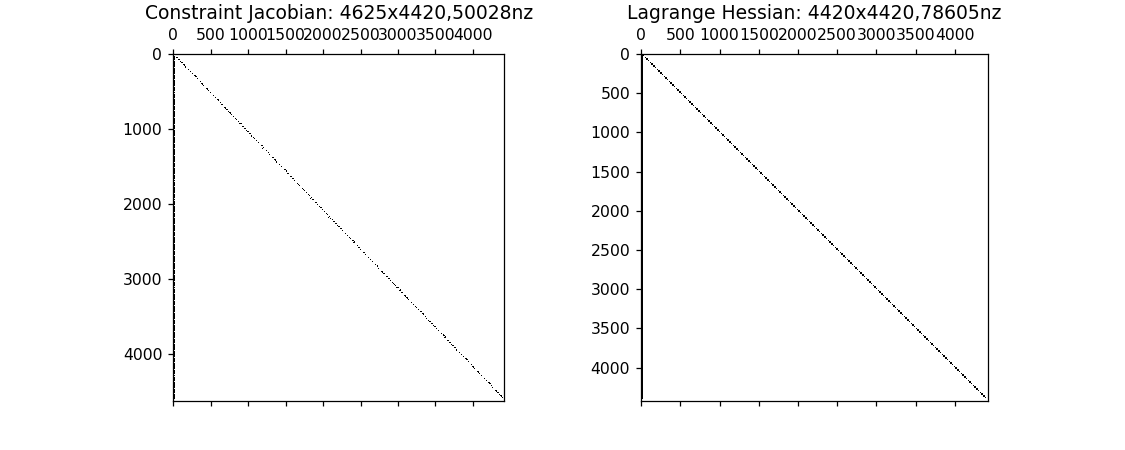

In [41]:
%matplotlib notebook

ocp.spy()

In [18]:
tsa, qa = sol.sample(q, grid='control')
# tsb, x1b = sol.sample(x1, grid='integrator')
# tsc, x1c = sol.sample(x1, grid='integrator', refine=100)
# plot(tsa, x1a, '-')
# plot(tsb, x1b, 'o')
# plot(tsc, x1c, '.')
qa # -4.34362998e-02, -5.85582404e-01, -7.53971357e-01, -2.94505902e-01

array([[ 1.00000000e+00, -6.32158792e-10, -4.50528490e-09,
        -1.54419712e-09],
       [ 9.99999995e-01, -5.66114113e-05, -5.68655177e-05,
        -5.53618998e-05],
       [ 9.99999926e-01, -2.25625033e-04, -2.26597287e-04,
        -2.22093295e-04],
       [ 9.99999624e-01, -5.06513915e-04, -5.08824667e-04,
        -4.99822380e-04],
       [ 9.99998868e-01, -8.36472848e-04, -9.03135411e-04,
        -8.88216190e-04],
       [ 9.99997499e-01, -1.10322642e-03, -1.40904000e-03,
        -1.38702220e-03],
       [ 9.99995309e-01, -1.26141770e-03, -2.02605326e-03,
        -1.99598477e-03],
       [ 9.99991945e-01, -1.31335861e-03, -2.75372719e-03,
        -2.71481156e-03],
       [ 9.99986949e-01, -1.25629950e-03, -3.59160573e-03,
        -3.54321880e-03],
       [ 9.99979753e-01, -1.08965145e-03, -4.53923686e-03,
        -4.48091836e-03],
       [ 9.99969682e-01, -8.13576238e-04, -5.59617096e-03,
        -5.52761870e-03],
       [ 9.99955951e-01, -4.28479496e-04, -6.76195984e-03,
      

<IPython.core.display.Javascript object>


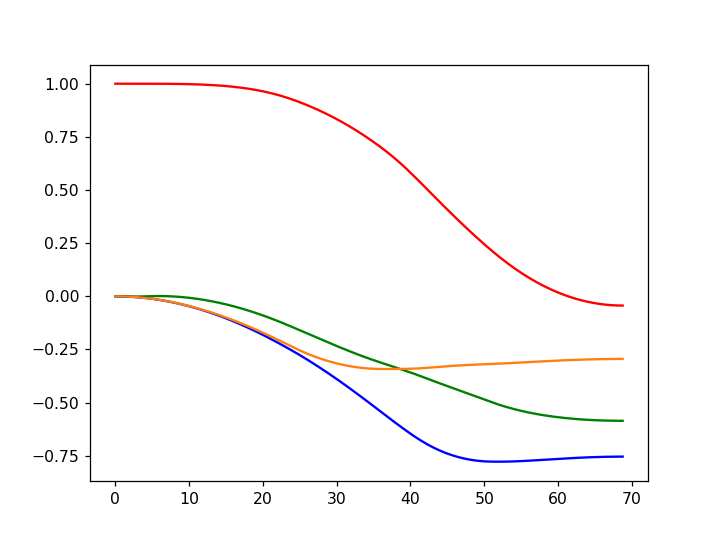

In [20]:
%matplotlib notebook
plt.plot(tsa, qa[:,0], 'r')
plt.plot(tsa, qa[:,1], 'g')
plt.plot(tsa, qa[:,2], 'b')
plt.plot(tsa, qa[:,3], 'tab:orange')
plt.show()

In [21]:
tsb, Vb = sol.sample(V, grid='control')

In [22]:
Vb

array([[ 5.98230703,  5.99993493,  5.99962846],
       [ 5.976251  ,  5.99993431,  5.99961887],
       [ 5.96647363,  5.99993368,  5.99960901],
       [-0.6802729 ,  5.99993304,  5.99959888],
       [-5.99019398,  5.99993238,  5.99958847],
       [-5.54635282,  5.9999317 ,  5.99957769],
       [-5.78774305,  5.99993101,  5.99956634],
       [-5.87758336,  5.99993028,  5.9995543 ],
       [-5.88933034,  5.99992954,  5.99954151],
       [-5.89989208,  5.99992876,  5.99952785],
       [-5.88514888,  5.99992796,  5.99951321],
       [-5.77416797,  5.99992713,  5.99949746],
       [ 5.99872657,  5.99992628,  5.99948048],
       [ 5.9991901 ,  5.99992539,  5.99946219],
       [ 5.99456294,  5.99992448,  5.99944257],
       [ 5.98145368,  5.99992354,  5.99942157],
       [ 5.95736937,  5.99992257,  5.99939912],
       [ 5.93581629,  5.99992157,  5.9993751 ],
       [ 5.93022218,  5.99992054,  5.99934938],
       [ 5.94138775,  5.99991949,  5.99932181],
       [ 5.95977979,  5.9999184 ,  5.999

<IPython.core.display.Javascript object>


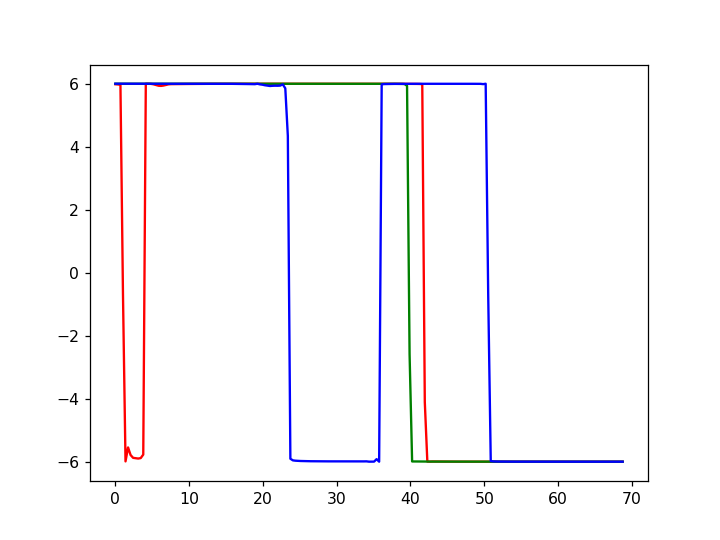

In [26]:
%matplotlib notebook
plt.plot(tsb, Vb[:,0], 'r')
plt.plot(tsb, Vb[:,1], 'g')
plt.plot(tsb, Vb[:,2], 'b')
plt.show()

In [30]:
tsc, wc = sol.sample(w, grid='control')

<IPython.core.display.Javascript object>


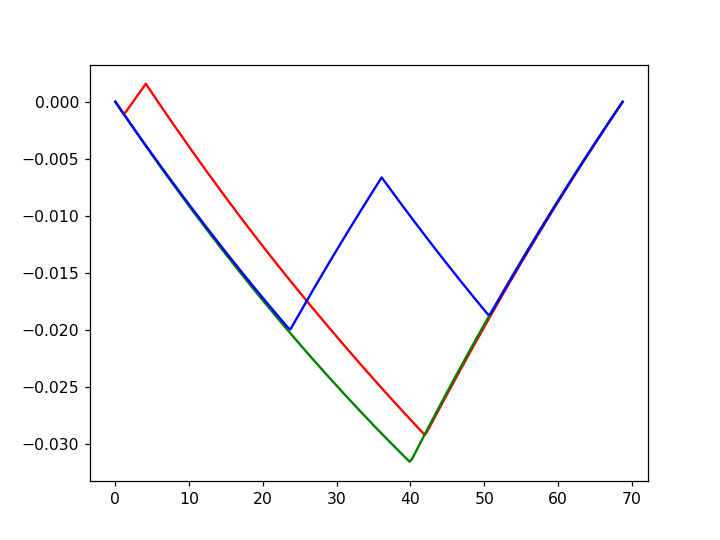

In [31]:
%matplotlib notebook
plt.plot(tsc, wc[:,0], 'r')
plt.plot(tsc, wc[:,1], 'g')
plt.plot(tsc, wc[:,2], 'b')
plt.show()

In [28]:
tsd, Omegad = sol.sample(Omega, grid='control')

<IPython.core.display.Javascript object>


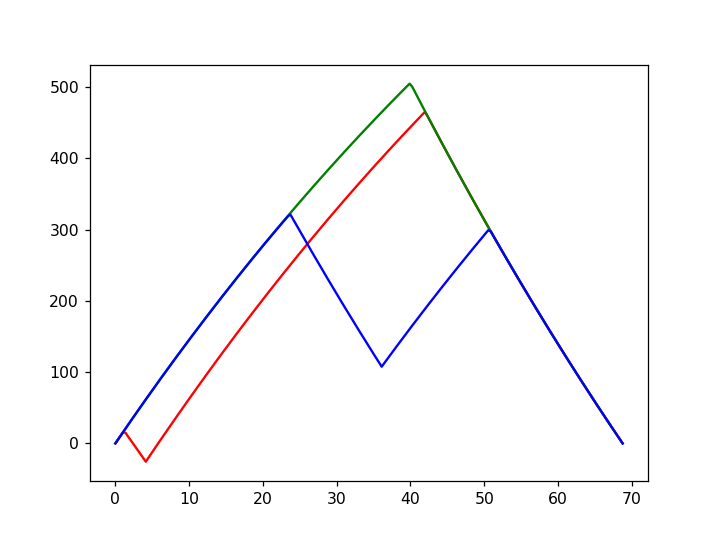

In [29]:
%matplotlib notebook
plt.plot(tsd, Omegad[:,0], 'r')
plt.plot(tsd, Omegad[:,1], 'g')
plt.plot(tsd, Omegad[:,2], 'b')
plt.show()

In [46]:
quat_desired = Quaternion(np.array([-0.0434363, -0.5855824, -0.7539713, -0.2945059]))

In [57]:
err = []
for quat in qa:
    quat_cur = Quaternion(quat)
    err.append(2*np.arccos((quat_cur.conjugate*quat_desired).real)*180/np.pi)

<IPython.core.display.Javascript object>


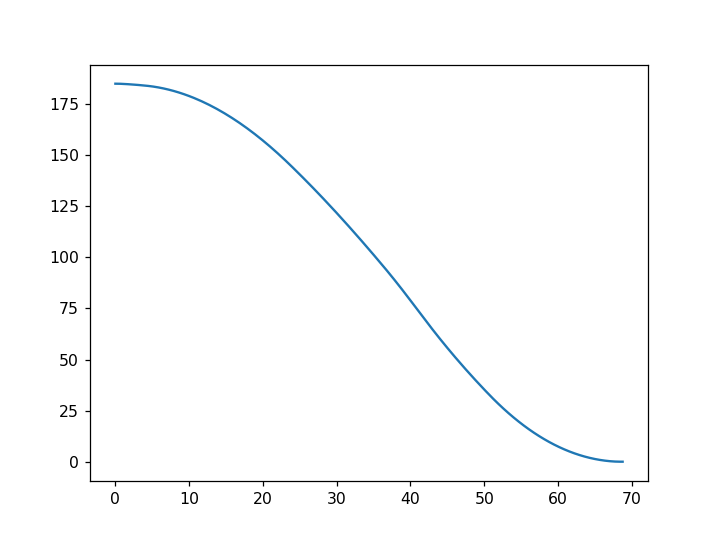

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

In [60]:
%matplotlib notebook
plt.plot(tsa, err)
plt.plot

In [61]:
err

[184.97899934537358,
 184.9684095920844,
 184.93674694755052,
 184.88409181385916,
 184.81470933413382,
 184.73619126493472,
 184.65163398374554,
 184.5609295790592,
 184.46430997212062,
 184.3618612182903,
 184.2536183205921,
 184.13959936914162,
 184.0197458279908,
 183.88654508036305,
 183.73258095678676,
 183.55791642248172,
 183.3626224995689,
 183.14678269837043,
 182.9104855353079,
 182.65380773089566,
 182.37680501648165,
 182.07951762496398,
 181.76197984175514,
 181.42423433704093,
 181.0663366408639,
 180.68834539885762,
 180.29031923825528,
 179.87231666665411,
 179.43439592943577,
 178.97661531852734,
 178.4990334031959,
 178.0017091211864,
 177.4847017984055,
 176.94807114904137,
 176.39187727173143,
 175.81618064844764,
 175.22104214740975,
 174.60652303009041,
 173.97268496150824,
 173.31959002355796,
 172.6473007313997,
 171.95588005175082,
 171.24539142367348,
 170.5158987829724,
 169.76746658553688,
 169.0001598345412,
 168.21404411489763,
 167.4091856271246,
 166.58